In [1]:
# import libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
from tensorflow.keras import layers, models
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()



11490434/11490434 [==============================] - 0s 0us/step


In [2]:
# Preprocess the data
train_images_new = train_images.reshape((60000, 784)).astype('float32') / 255
test_images_new = test_images.reshape((10000, 784)).astype('float32') / 255
#train_images = train_images.reshape((60000, 784, 1)).astype('float32') / 255 # for channel info 1 channel grayscale

# Convert labels to one-hot encoding
#train_labels = tf.keras.utils.to_categorical(train_labels)
#test_labels = tf.keras.utils.to_categorical(test_labels)


In [3]:
train_labels.shape

(60000,)

In [29]:
# Use MLP (3 hidden layers) on original data to find

model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(784,)),
    layers.Dropout(0.2),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
import time
start = time.time()

# Train the model
model.fit(train_images_new, train_labels, epochs=5, batch_size=128)

end = time.time()
total = end - start
print(f"Elapsed time to train MLP: {total:.3f} seconds")


# Evaluate the model
test_loss, test_acc = model.evaluate(test_images_new, test_labels)
print('Test accuracy:', test_acc)

Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.3453 - accuracy: 0.8962
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.1378 - accuracy: 0.9596
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0980 - accuracy: 0.9711
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0790 - accuracy: 0.9763
Epoch 5/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0663 - accuracy: 0.9801
Elapsed time to train MLP: 11.232 seconds
313/313 [==============================] - 1s 2ms/step - loss: 0.0738 - accuracy: 0.9771
Test accuracy: 0.9771000146865845


In [30]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 512)               401920    
                                                                 
 dropout_31 (Dropout)        (None, 512)               0         
                                                                 
 dense_47 (Dense)            (None, 128)               65664     
                                                                 
 dropout_32 (Dropout)        (None, 128)               0         
                                                                 
 dense_48 (Dense)            (None, 64)                8256      
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 10)              

In [20]:
# Data centering by subtracting from mean
x = np.concatenate((train_images_new,test_images_new), axis=0)

mean = x.mean(axis=1)
x = x - mean[:,None]
x.shape

x_train = x[:60000,:]
x_test = x[60000:,:]


**Horn's parallel analysis - Random permutations are done in the features of data by shuffling. Eigen values are found using SVD. Top k relevant principal components are found by chosing a suitable threshold (0.05) such that we keep only those eigen values whose p-value is smaller than the threshold.**

In [21]:
# use Horn paralell analysis based on SVD to find optimal K for PCA

R=50 # repititions

# calculate the singular values of original centred matrix x_train (training dataset)
eval_origi = np.linalg.svd(x_train, compute_uv=False)

# Initialize an array to save the counts of how many times each singular value of the original matrix is less than the shuffled matrix
number=np.zeros(shape=eval_origi.shape)

# Define another matrix for random permutations
x2 =x_train

for i in range(R):

    # shuffle each column of matrix independently
    for j in range(x2.shape[1]):
        np.random.shuffle(x2[:,j])

    #eval_origi = np.linalg.svd(x, compute_uv=False)
    eval2 = np.linalg.svd(x2, compute_uv=False)

    # Compare the singular values of the shuffled matrix with the original matrix
    for k in range(number.shape[0]):
       if(eval2[k]>eval_origi[k]):
           number[k]=number[k]+1;

# number represenst the number of times eigenvalue of original matrix is less than random shuffled
pval=(number)/(R)

In [22]:
# count the eigen values whose pvalue is less than 0.05 (threshold)
count = np.sum(pval < 0.05)
count

47

 **The top 47 principal components capture the data as per Horn analysis**


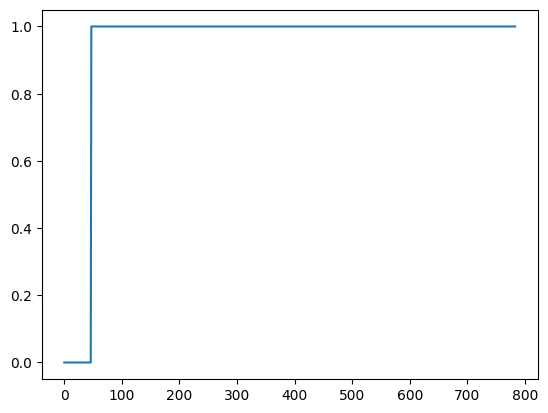

In [23]:
import matplotlib.pyplot as plt
plt.plot(pvals)

In [3]:
# Data centering by subtracting from mean
x = np.concatenate((train_images_new,test_images_new), axis=0)

mean = x.mean(axis=1)
x = x - mean[:,None]
x.shape

x_train = x[:60000,:]
x_test = x[60000:,:]

In [32]:
# use PCA to reduce data dimesnionality and test the accuracy on top k principal componenets

k=47
from sklearn.decomposition import PCA
pca = PCA(n_components=k)  # You can adjust the number of components as needed

# Fit PCA on training data
pca.fit(x_train)

# Transform training and test data
train_images_pca = pca.transform(x_train)#train_images_new)
test_images_pca = pca.transform(x_test)#test_images_new)

model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(k,)),
    layers.Dropout(0.2),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
import time
start = time.time()
# Train the model
model.fit(train_images_pca, train_labels, epochs=5, batch_size=128)

end = time.time()
total = end - start
print(f"Elapsed time to train MLP: {total:.3f} seconds")

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images_pca, test_labels)
print('Test accuracy:', test_acc)

Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.3650 - accuracy: 0.8916
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 0.1478 - accuracy: 0.9570
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.1103 - accuracy: 0.9677
Epoch 4/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0921 - accuracy: 0.9724
Epoch 5/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0799 - accuracy: 0.9755
Elapsed time to train MLP: 10.981 seconds
313/313 [==============================] - 1s 2ms/step - loss: 0.0615 - accuracy: 0.9809
Test accuracy: 0.98089998960495


In [33]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 512)               24576     
                                                                 
 dropout_34 (Dropout)        (None, 512)               0         
                                                                 
 dense_51 (Dense)            (None, 128)               65664     
                                                                 
 dropout_35 (Dropout)        (None, 128)               0         
                                                                 
 dense_52 (Dense)            (None, 64)                8256      
                                                                 
 dropout_36 (Dropout)        (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 10)              

In [16]:
# variance of data from these PCs

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", sum(explained_variance_ratio))

Explained variance ratio: 0.8095900062471628


 The top 47 PCs collectively explain more than 80% of the total variance in the dataset. This indicates that a significant amount of the dataset's variability can be captured by these 47 principal components.
 When we project your data onto these 47 PCs, we retain 80% of the original information contained in the dataset  

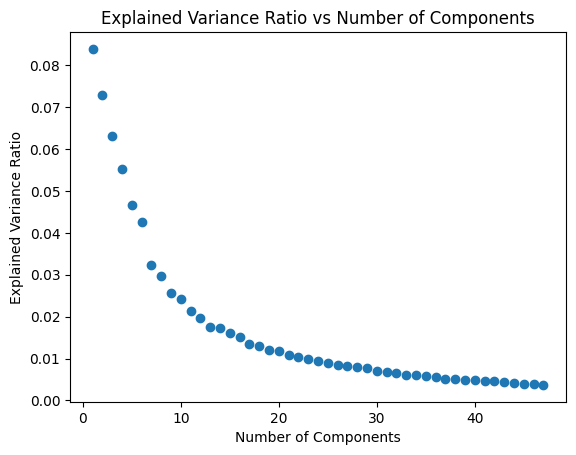

In [10]:
import matplotlib.pyplot as plt

# Plot explained variance ratio
plt.scatter(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Components')
plt.grid(False)
plt.show()


**2D and 3D visualisation of top 2 and 3 PCs of MNIST dataset**

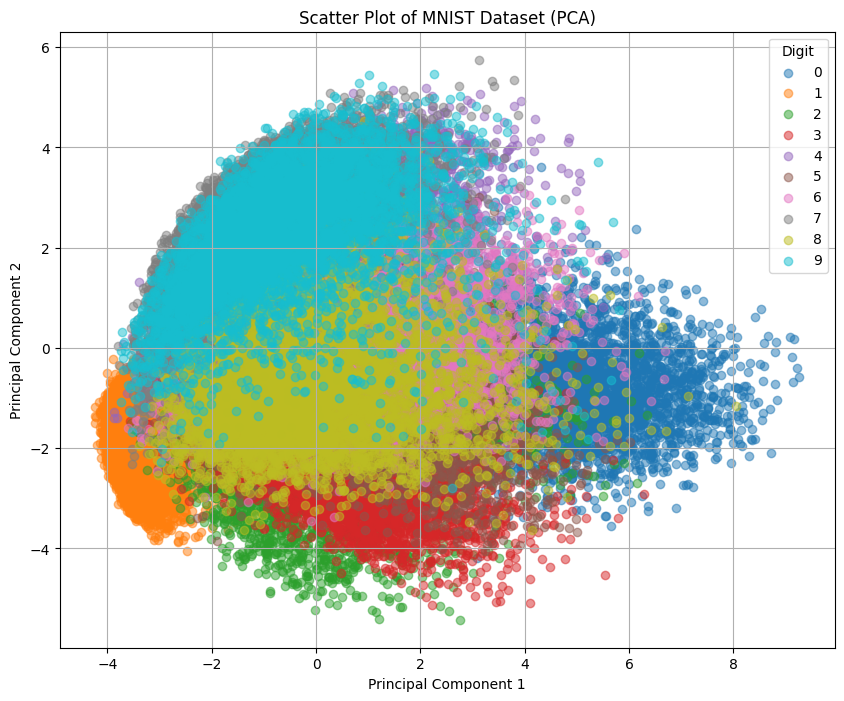

In [49]:
pca = PCA(n_components=2)
mnist_pca = pca.fit_transform(train_images_new)

# Create a scatter plot of the reduced data
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(mnist_pca[train_labels == i, 0], mnist_pca[train_labels == i, 1], label=str(i), alpha=0.5)
plt.title('Scatter Plot of MNIST Dataset (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Digit')
plt.grid(True)
plt.show()

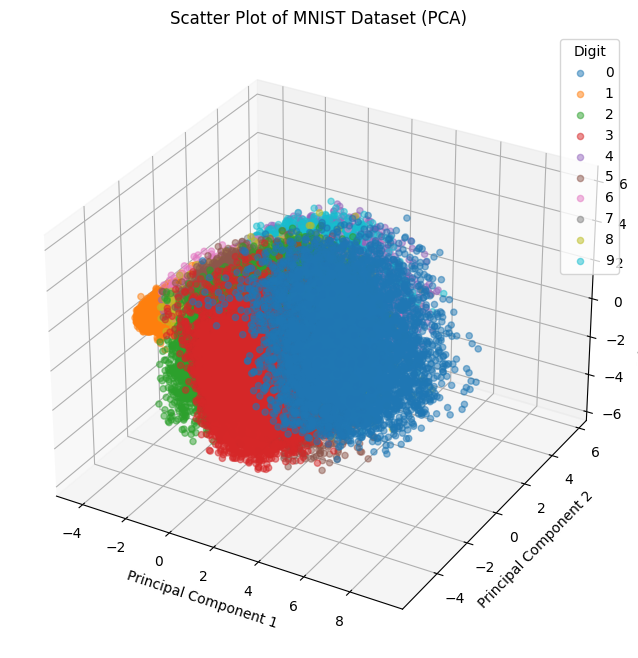

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Reduce the dimensionality of the MNIST dataset using PCA
pca = PCA(n_components=3)
mnist_pca = pca.fit_transform(train_images_new)

# Create a scatter plot of the reduced data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(10):
    ax.scatter(mnist_pca[train_labels == i, 0],
               mnist_pca[train_labels == i, 1],
               mnist_pca[train_labels == i, 2],
               label=str(i), alpha=0.5)
ax.set_title('Scatter Plot of MNIST Dataset (PCA)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend(title='Digit')
plt.show()


**It can be observed that we require at least the order of 10 PCs for visualisation. The top 2-3 PCs do capture some information but insufficient to draw classification boundaries**

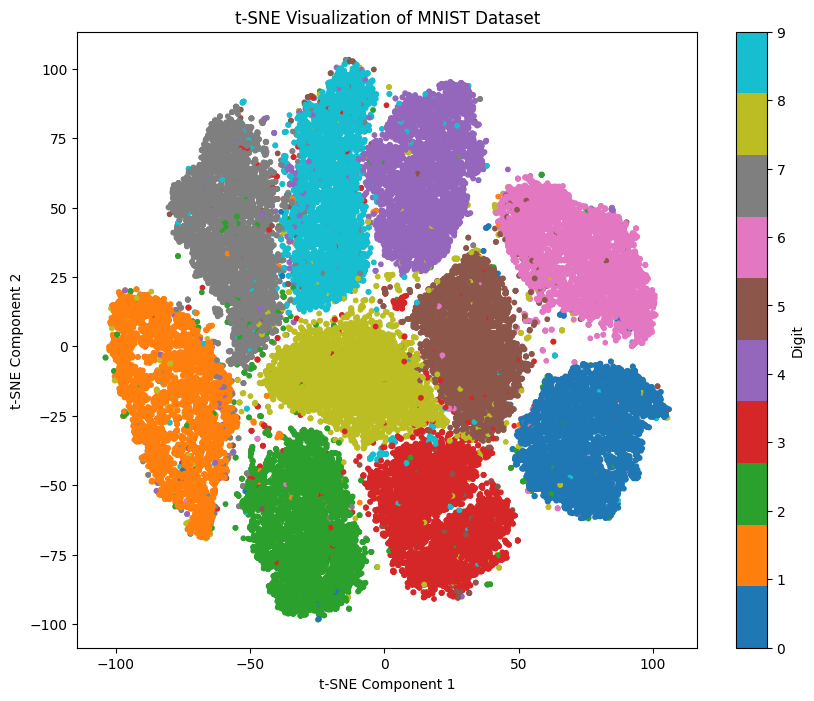

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reduce the dimensionality of the MNIST dataset using t-SNE
tsne = TSNE(n_components=2, random_state=42)
mnist_tsne = tsne.fit_transform(train_images_new)

#  scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(mnist_tsne[:, 0], mnist_tsne[:, 1], c=train_labels, cmap='tab10', s=10)
plt.title('t-SNE Visualization of MNIST Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Digit')
plt.show()


**t-SNE embeddings seem to provide a good visualisation of the MNIST data in the 2D space. In the case of MNIST, t-SNE is often able to capture the local and global structure of the digits more effectively compared to PCA. This is because t-SNE is better at preserving the intricate relationships and clusters present in the high-dimensional data, resulting in a more visually appealing and informative 2D visualization.**

# Data reduction and visualization

PCA works by finding the directions (principal components) of maximum variance in the data and projecting the data onto a lower-dimensional subspace defined by these components. However, in the case of MNIST, much of the variance in the data may not be captured effectively by just a few principal components.

On the other hand, t-SNE (t-distributed Stochastic Neighbor Embedding) is a non-linear dimensionality reduction technique that is particularly well-suited for visualizing high-dimensional data in lower-dimensional spaces such as 2D or 3D. t-SNE works by preserving local and global structure in the data, meaning that similar data points in the high-dimensional space are likely to remain close to each other in the low-dimensional embedding.